# 0. Instructions and setup

## 0.1. Instructions. Part 1: Setting Up the Problem (1.5 points)

- **Objective**: Understand and establish the baseline for your chosen dataset.

- **Tasks:**
  - **a. Bibliography and SOA (0.25 points):** Present briefly your task by researching and documenting the main  objective, a potential business case and the current state of the art  for your dataset's task. Include relevant benchmarks and methodologies.  You can look at google scholar, NLP index or papers with code. 
  - **b. Dataset Description (0.5 points):** Provide a brief overview of your dataset, including size, class  distribution, and any peculiar characteristics. Include basic  descriptive statistics.
  - **c. Random Classifier Performance (0.25 points):** Calculate the expected performance of a random classifier for your  dataset to set a benchmark. The calculation should include an  implementation. 
  - **d. Baseline Implementation (0.5 points):** Develop a rule-based classifier as a baseline. Discuss its performance in the  context of the dataset's complexity and compare it with human-level  performance if available.

## 0.2. Libraries

In [29]:
# !pip install polars  # Install polars for faster data processing

In [2]:
from datasets import load_dataset
from pprint import pprint
import polars as pl
import seaborn as sns
import random
from library.metrics import Metrics
import matplotlib.pyplot as plt
import numpy as np
from library.utilities import set_seed

In [3]:
# Initialize the metrics object to save the results
metrics = Metrics()

## 0.3. Random Seed

In [4]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


# 1. Bibliography and SOA

# 2. Dataset Description: Swiss Judgement Prediction

Source: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

## 2.1. Loading and reestructuring the data

In [6]:
# Load original dataset (with the original languages)
swiss_french = load_dataset('swiss_judgment_prediction', 'fr', trust_remote_code=True)

In [7]:
# Print the dataset structure for the French version
print("French version of the dataset:\n", swiss_french)

French version of the dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 21179
    })
    validation: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 3095
    })
    test: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 6820
    })
})


In [28]:
# Access the first example in the training set
pprint(swiss_french['train'][0])

# Access the first example in the validation set
pprint(swiss_french['validation'][0])

# Access the first example in the test set
pprint(swiss_french['test'][0])

{'canton': 'n/a',
 'id': 0,
 'label': 0,
 'language': 'fr',
 'legal area': 'civil law',
 'region': 'n/a',
 'source_language': 'n/a',
 'text': "A.- Par contrat d'entreprise signé le 2 octobre 1998, Narcisse "
         'Pannatier, domicilié à Sion, a adjugé à Georges-André Dorsaz les '
         "travaux de construction d'une charpente pour une villa sise à Fully, "
         'dans le district de Martigny. Le 11 novembre 1998, Georges-André '
         'Dorsaz a adressé à Narcisse Pannatier une facture de 16 179 fr.85. '
         "Le maître de l'ouvrage a payé 15 712 fr.55. Diverses tentatives de "
         "recouvrement du solde à l'amiable ont échoué. B.- Par demande des 23 "
         'novembre/3 décembre 1999, Georges-André Dorsaz a ouvert action '
         'contre Narcisse Pannatier devant le juge de commune de Fully en vue '
         "d'obtenir le paiement de 467 fr. plus intérêts. Le juge de commune a "
         'fixé une audience au 4 février 2000. Le demandeur a donné suite à '
    

In [12]:
print(swiss_french['train'])

Dataset({
    features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
    num_rows: 21179
})


In [18]:
# Convert to Polars DataFrames with split column
train_df = pl.DataFrame(swiss_french['train'].to_pandas())
train_df = train_df.with_columns(pl.lit("train").alias("split"))

val_df = pl.DataFrame(swiss_french['validation'].to_pandas())
val_df = val_df.with_columns(pl.lit("validation").alias("split"))

test_df = pl.DataFrame(swiss_french['test'].to_pandas())
test_df = test_df.with_columns(pl.lit("test").alias("split"))

# Combine into a single DataFrame
combined_df = pl.concat([train_df, val_df, test_df], how='vertical')

print(f"Combined DataFrame shape: {combined_df.shape}")
print(f"Distribution of splits: {combined_df.group_by('split').len().sort('split')}")

Combined DataFrame shape: (31094, 10)
Distribution of splits: shape: (3, 2)
┌────────────┬───────┐
│ split      ┆ len   │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ test       ┆ 6820  │
│ train      ┆ 21179 │
│ validation ┆ 3095  │
└────────────┴───────┘


In [19]:
# Remove columns that are not needed for the final dataset
columns_to_remove = ['source_language']
combined_df = combined_df.drop(columns_to_remove)

# Clean up "n/a" strings in several columns to actual NaN values
columns_to_clean = ['region', 'canton', 'legal area']

for column in columns_to_clean:
    combined_df = combined_df.with_columns(
        pl.col(column).replace("n/a", None)
    )

# Rename 'label' column to 'labels' to match Hugging Face expectations
combined_df = combined_df.rename({"label": "labels"})

print("\nFirst few rows:")
combined_df.head()


First few rows:


id,year,text,labels,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


In [20]:
# Save the combined DataFrame to a Parquet file
combined_df.write_parquet('data/FRENCH_swiss_judgment_prediction_combined.parquet')

## 2.2. EDA

**Data fields**:
- id: (int) a unique identifier of the for the document
- year: (int) the publication year
- text: (str) the facts of the case
- label: (class label) the judgment outcome: 0 (dismissal) or 1 (approval)
- language: (str) one of (de, fr, it)
- region: (str) the region of the lower court
- canton: (str) the canton of the lower court
- legal area: (str) the legal area of the case 

In [ ]:
# Load the cleaned Parquet file
df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_combined.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()


Loaded DataFrame shape: (31094, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'labels': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,labels,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


shape: (3, 5)
┌────────────┬───────┬──────┬───────┬───────┐
│ split      ┆ 0     ┆ 1    ┆ 0_pct ┆ 1_pct │
│ ---        ┆ ---   ┆ ---  ┆ ---   ┆ ---   │
│ str        ┆ u32   ┆ u32  ┆ f64   ┆ f64   │
╞════════════╪═══════╪══════╪═══════╪═══════╡
│ train      ┆ 15982 ┆ 5197 ┆ 75.46 ┆ 24.54 │
│ validation ┆ 2446  ┆ 649  ┆ 79.03 ┆ 20.97 │
│ test       ┆ 5556  ┆ 1264 ┆ 81.47 ┆ 18.53 │
└────────────┴───────┴──────┴───────┴───────┘


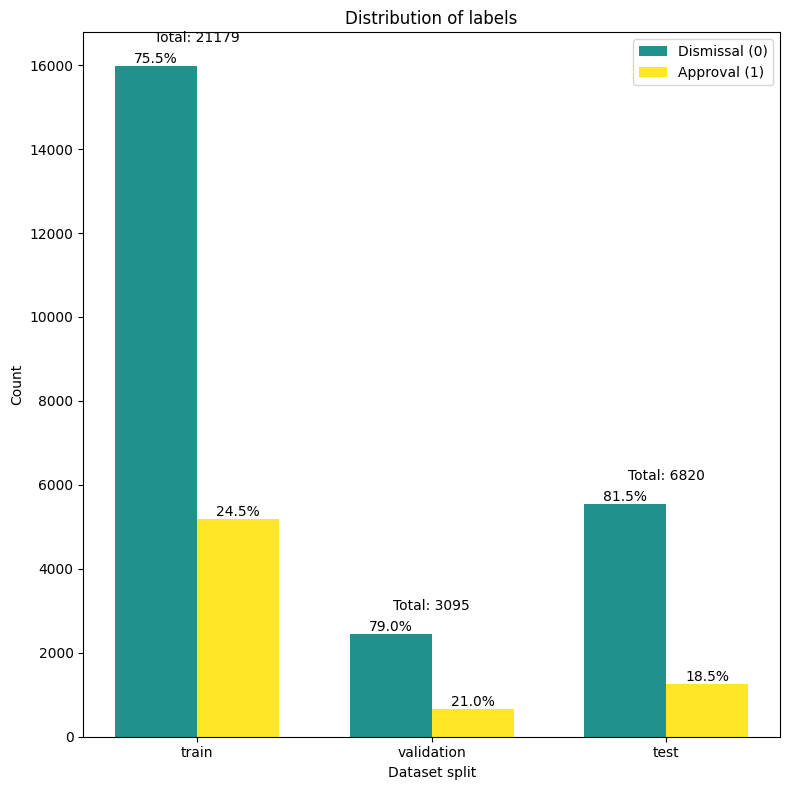

In [23]:
label_distribution = df.group_by(['split', 'labels']).len().sort(['split', 'labels'])

# pivot
label_pivot = label_distribution.pivot(
    index='split',
    on='labels',
    values='len'
).sort(['split'])

total_by_split = label_pivot.select(pl.col('0') + pl.col('1')).rename({'0': 'total'})
label_pivot_with_pct = label_pivot.with_columns([
    (pl.col('0') / (pl.col('0') + pl.col('1')) * 100).round(2).alias('0_pct'), # percentages for each labels
    (pl.col('1') / (pl.col('0') + pl.col('1')) * 100).round(2).alias('1_pct')
])

# reorder and pivot
split_order = {'train': 0, 'validation': 1, 'test': 2}
label_pivot = label_pivot.filter(
    pl.col('split').is_in(['train', 'validation', 'test'])
).with_columns(
    pl.col('split').map_elements(lambda x: split_order.get(x, 99), return_dtype=pl.Int64).alias('sort_key')
).sort('sort_key').drop('sort_key')

label_pivot_with_pct = label_pivot_with_pct.filter(
    pl.col('split').is_in(['train', 'validation', 'test'])
).with_columns(
    pl.col('split').map_elements(lambda x: split_order.get(x, 99), return_dtype=pl.Int64).alias('sort_key')
).sort('sort_key').drop('sort_key')

print(label_pivot_with_pct)

ordered_splits = ['train', 'validation', 'test']
label_0_counts = label_pivot.select('0').to_numpy().flatten()
label_1_counts = label_pivot.select('1').to_numpy().flatten()

fig, ax = plt.subplots(figsize=(8, 8))
width = 0.35
x = np.arange(len(ordered_splits))

bar1 = ax.bar(x - width/2, label_0_counts, width, label='Dismissal (0)', color=plt.cm.viridis(np.linspace(0.5, 0.5, 3)))
bar2 = ax.bar(x + width/2, label_1_counts, width, label='Approval (1)', color=plt.cm.viridis(np.linspace(1, 1, 3)))

for i, bar in enumerate(bar1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{label_pivot_with_pct["0_pct"][i]:.1f}%', 
            ha='center', va='bottom')

for i, bar in enumerate(bar2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{label_pivot_with_pct["1_pct"][i]:.1f}%', 
            ha='center', va='bottom')

ax.set_xlabel('Dataset split')
ax.set_ylabel('Count')
ax.set_title('Distribution of labels')
ax.set_xticks(x)
ax.set_xticklabels(ordered_splits)
ax.legend()

for i in range(len(ordered_splits)):
    total = label_0_counts[i] + label_1_counts[i]
    ax.text(i, max(label_0_counts[i], label_1_counts[i]) + 500, 
            f'Total: {total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. Random Classifier Performance

Metrics calculated for: random_classifier_train
Metrics calculated for: random_classifier_validation
Metrics calculated for: random_classifier_test


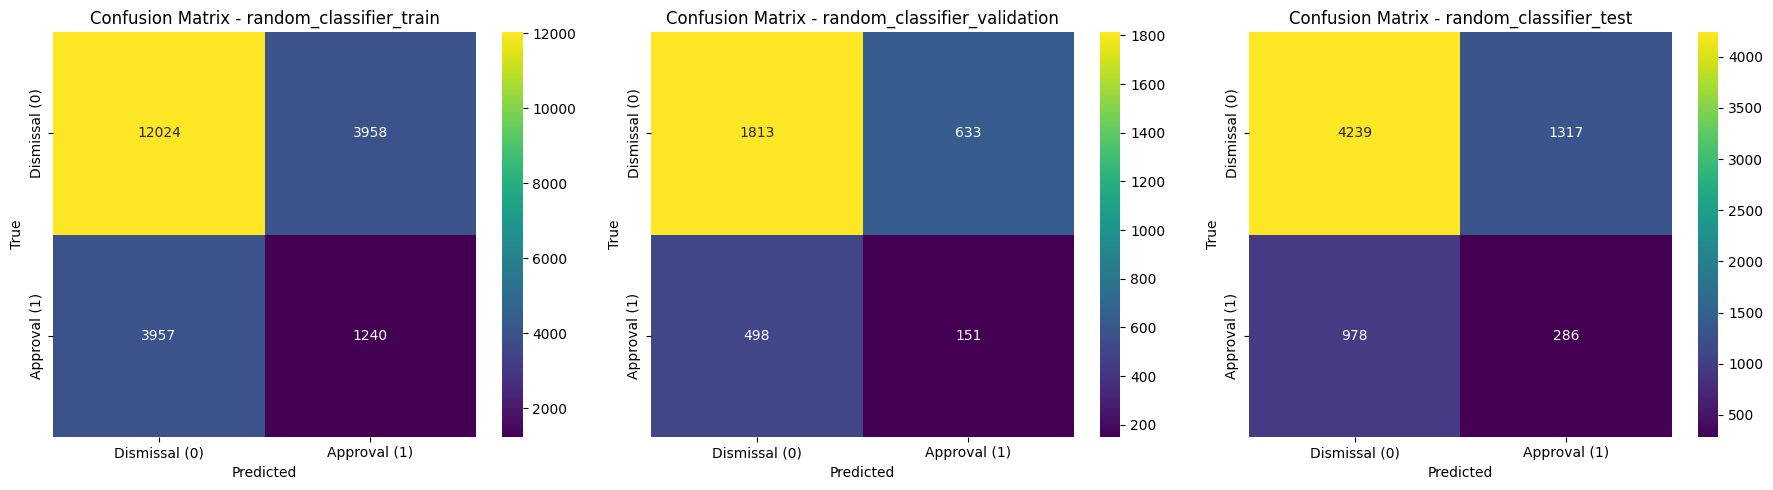

Expected accuracy of a random classifier based on majority class of 'train' set: 75.46%
Expected accuracy of a random classifier based on class probabilities of 'train' set: 62.97%

Metrics for random_classifier_train

Accuracy: 62.63%

Precision: 23.86%

Recall: 23.86%

F1 Score: 23.86%

Metrics for random_classifier_validation

Accuracy: 63.46%

Precision: 19.26%

Recall: 23.27%

F1 Score: 21.07%

Metrics for random_classifier_test

Accuracy: 66.35%

Precision: 17.84%

Recall: 22.63%

F1 Score: 19.95%


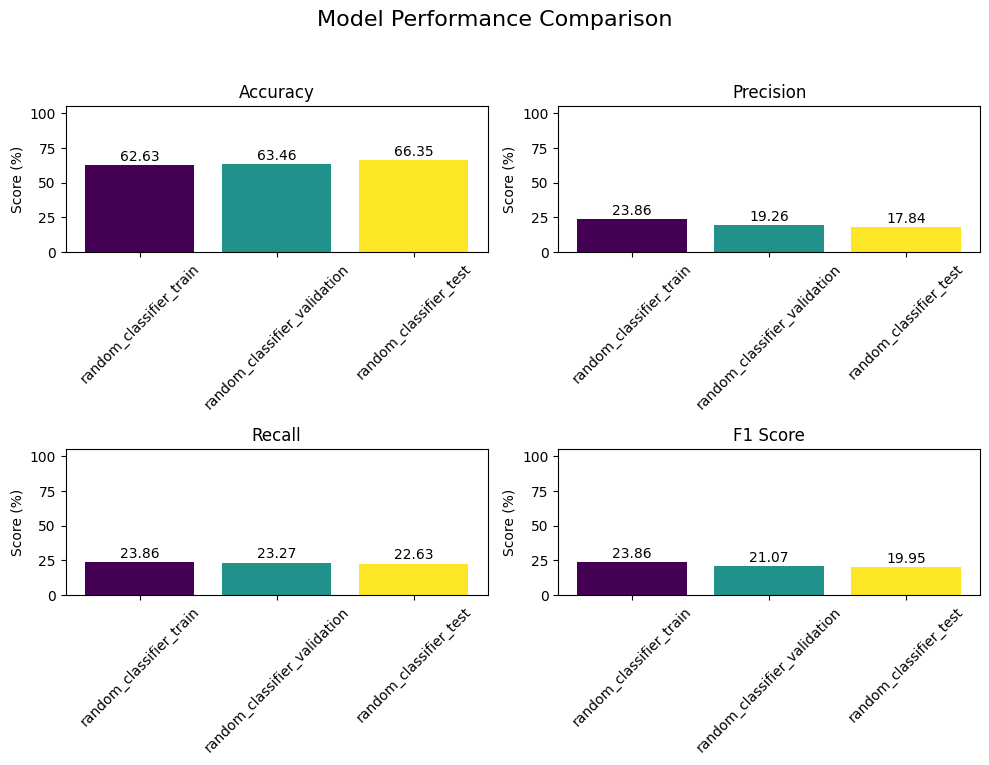

In [24]:
def random_classifier(data, split_name):
    split_data = data.filter(pl.col('split') == split_name)
    
    # labels distribution from train
    label_dist_train = df.filter(pl.col('split') == 'train').group_by('labels').len()
    total_train = label_dist_train['len'].sum()
    class_probs = {row['labels']: row['len'] / total_train for row in label_dist_train.to_dicts()}
    
    y_true = split_data.select('labels').to_numpy().flatten()
    y_pred = np.random.choice([0, 1], size=len(y_true), p=[class_probs[0], class_probs[1]])
    
    return y_true, y_pred, class_probs

# compute and plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, split in enumerate(['train', 'validation', 'test']):
    y_true, y_pred, class_probs = random_classifier(df, split)
    
    metrics.run(y_true, y_pred, f'random_classifier_{split}', average='binary')
    metrics.plot_confusion_matrix(y_true, y_pred, f"random_classifier_{split}", ax=axes[i])

plt.tight_layout()
plt.show()

# expected results of random classifyer
majority_class_percentage = class_probs[0] * 100  # Assuming class '1' is the majority class
print(f"Expected accuracy of a random classifier based on majority class of 'train' set: {majority_class_percentage:.2f}%")
random_accuracy = (class_probs[0]**2 + class_probs[1]**2) *100
print(f"Expected accuracy of a random classifier based on class probabilities of 'train' set: {random_accuracy:.2f}%")

# print results of random classifier
metrics.print_results()
metrics.plot()

Expected performance of a random classifier depends on the class distribution, not just the number of classes (two in our case). Our **class distribution for the 'train' set is 75.5% of Dismissals (label 0) and 24.5% of Approvals (label 1)**. A random classifier that guesses proportionately to the class distribution will have the expected accuracy of:

$$Accuracy = prob(class 0)^2 + prob(class)^2 = 0.755^2 + 0.245^2 = 0.63$$

As we see, on the test set, the accuracy is slightly higher because the test set is even more imbalanced (81.5% Dismissals vs 18.5% Approvals). And as imbalance increases, the probability of the majority class approaches 1, and the expected accuracy of a random classifier approaches 100%.

Another strategy -- **always predicting the majority class** -- would give us even a higher **accuracy of 81.5% on the test set**, which could be used as another benchmark.

# 4. Baseline Implementation